## basline CNN model 




In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# Project modules
from utils import *
from utils_visualisation import *
from Data_Handler import ClimbingDataset
from models import *
from trainer import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import MulticlassAccuracy


# Image filters
import kornia.filters as KF




/home/fillies/Documents/moon/kilter/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
transform = KF.GaussianBlur2d(kernel_size=(3, 3), sigma=(1.0, 1.0), border_type="constant")

climbing_DB = ClimbingDataset(board_names=["12 x 12 with kickboard Square"],#, "8 x 12 Home"],
                            map=True, 
                            transform=transform,
                            #label_filter=[5, 14],
                            max_samples=10000 
)
num_classes = climbing_DB.num_classes


10000
torch.Size([4, 35, 35]) torch.Size([21])


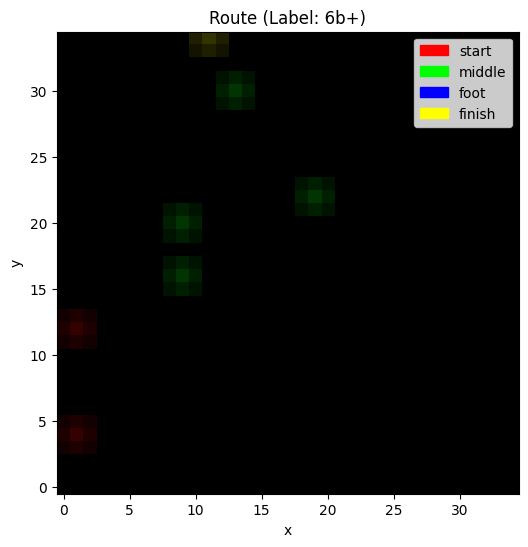

In [20]:
print(len(climbing_DB))

X, y = climbing_DB[15]

print(X.shape, y.shape)
plot_route(X, torch.argmax(y))



In [21]:

train_size = int(0.8 * len(climbing_DB))  # 80% train
test_size = len(climbing_DB) - train_size

# Deterministic split (set generator seed for reproducibility)
train_dataset, test_dataset = random_split(
    climbing_DB,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Wrap in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")





Train samples: 8000, Test samples: 2000


Approx dataset tensor size: 196.84 MB
Train distribution:
  Class 4c: 45.0 (0.6%)
  Class 5a: 190.0 (2.4%)
  Class 5b: 114.0 (1.4%)
  Class 5c: 216.0 (2.7%)
  Class 6a: 285.0 (3.6%)
  Class 6a+: 357.0 (4.5%)
  Class 6b: 528.0 (6.6%)
  Class 6b+: 528.0 (6.6%)
  Class 6c: 644.0 (8.1%)
  Class 6c+: 515.0 (6.4%)
  Class 7a: 719.0 (9.0%)
  Class 7a+: 607.0 (7.6%)
  Class 7b: 800.0 (10.0%)
  Class 7b+: 886.0 (11.1%)
  Class 7c: 565.0 (7.1%)
  Class 7c+: 358.0 (4.5%)
  Class 8a: 284.0 (3.5%)
  Class 8a+: 207.0 (2.6%)
  Class 8b: 126.0 (1.6%)
  Class 8b+: 21.0 (0.3%)

Test distribution:
  Class 4c: 16.0 (0.8%)
  Class 5a: 55.0 (2.8%)
  Class 5b: 30.0 (1.5%)
  Class 5c: 52.0 (2.6%)
  Class 6a: 55.0 (2.8%)
  Class 6a+: 102.0 (5.1%)
  Class 6b: 151.0 (7.6%)
  Class 6b+: 145.0 (7.2%)
  Class 6c: 140.0 (7.0%)
  Class 6c+: 133.0 (6.7%)
  Class 7a: 193.0 (9.6%)
  Class 7a+: 119.0 (5.9%)
  Class 7b: 193.0 (9.6%)
  Class 7b+: 217.0 (10.9%)
  Class 7c: 151.0 (7.6%)
  Class 7c+: 88.0 (4.4%)
  Class 8a: 7

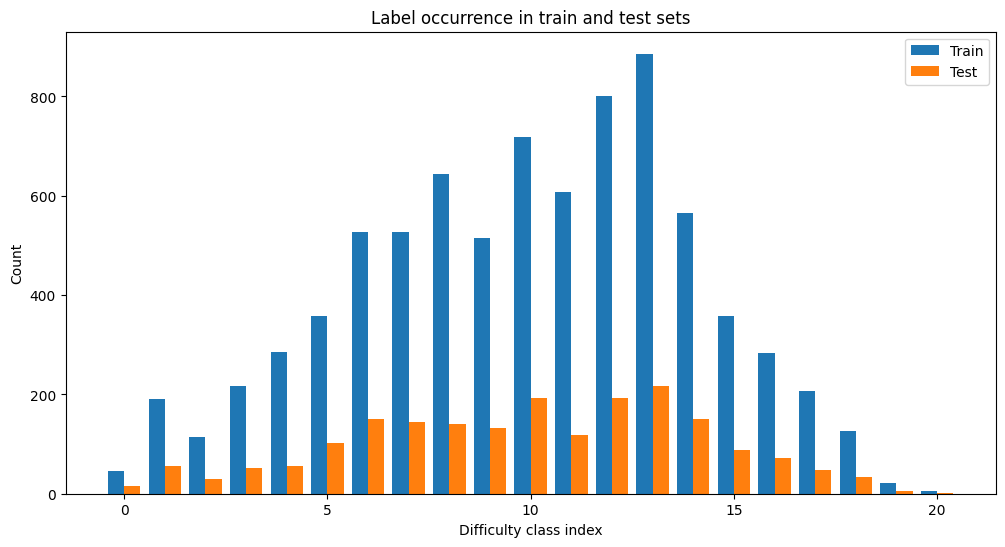

In [22]:
# Some visualisations and Data demand: 
total_bytes = 0
for data, target in train_dataset:
    if isinstance(data, torch.Tensor):
        total_bytes += data.element_size() * data.nelement()
    if isinstance(target, torch.Tensor):
        total_bytes += target.element_size() * target.nelement()
        
for data, target in test_dataset:
    if isinstance(data, torch.Tensor):
        total_bytes += data.element_size() * data.nelement()
    if isinstance(target, torch.Tensor):
        total_bytes += target.element_size() * target.nelement()
        
print("Approx dataset tensor size:", total_bytes / 1e6, "MB")

#

#print(measure_loader_time(train_loader, num_batches=200))
#print_hold_statistics(train_dataset, num_classes=climbing_DB.num_classes )
plot_label_distribution(train_dataset, test_dataset, num_classes=climbing_DB.num_classes)




In [23]:
torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [42]:
model_0 = shallowCNN(input_shape= 4,hidden_units_CNN= 16, hidden_units_classifier=  16, output_shape=num_classes ).to(device)
model_0

class SimpleAccuracy:
    def reset(self):
        pass  # no state to reset
    
    def __call__(self, y_pred, y_true):
        return multiclass_accuracy(y_pred, y_true)

def multiclass_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    """
    Compute multiclass accuracy.
    
    Parameters
    ----------
    y_pred : torch.Tensor
        Model outputs, shape [N, num_classes], raw logits or probabilities.
    y_true : torch.Tensor
        Ground truth labels, shape [N], as integer class indices.
    
    Returns
    -------
    float
        Accuracy = correct / total.
    """
    # predicted class = argmax over class dimension
    correct = (y_pred == y_true).sum()
    total = y_true.size(0)
    return correct / total

loss_fn = torch.nn.BCEWithLogitsLoss()
acc_fn = SimpleAccuracy()# MulticlassAccuracy(num_classes=num_classes).to(device)
optimizer = optim.Adam(model_0.parameters(), lr=1e-3, weight_decay=1e-4 )


In [43]:
model, history = train_model(
    model=model_0,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    acc_fn=acc_fn,
    device=device,
    epochs=10,
    patience=50
)


Epoch 0000 | Train loss: 0.35690 | Train acc: 0.05287 | Test loss: 0.18033 | Test acc: 0.11062
Timing: total 11.128 s | train 9.682 s | eval 1.446 s

Epoch 0001 | Train loss: 0.17868 | Train acc: 0.11013 | Test loss: 0.17960 | Test acc: 0.10417
Timing: total 11.048 s | train 9.368 s | eval 1.679 s

Epoch 0002 | Train loss: 0.17744 | Train acc: 0.11038 | Test loss: 0.19864 | Test acc: 0.12500
Timing: total 10.071 s | train 8.525 s | eval 1.546 s

Epoch 0003 | Train loss: 0.17575 | Train acc: 0.11787 | Test loss: 0.18709 | Test acc: 0.12996
Timing: total 10.172 s | train 8.649 s | eval 1.523 s

Epoch 0004 | Train loss: 0.17359 | Train acc: 0.13012 | Test loss: 0.17462 | Test acc: 0.12798
Timing: total 10.237 s | train 9.012 s | eval 1.225 s

Epoch 0005 | Train loss: 0.17170 | Train acc: 0.13412 | Test loss: 0.17049 | Test acc: 0.13839
Timing: total 9.805 s | train 8.408 s | eval 1.397 s

Epoch 0006 | Train loss: 0.17050 | Train acc: 0.13612 | Test loss: 0.17117 | Test acc: 0.13145
Timin

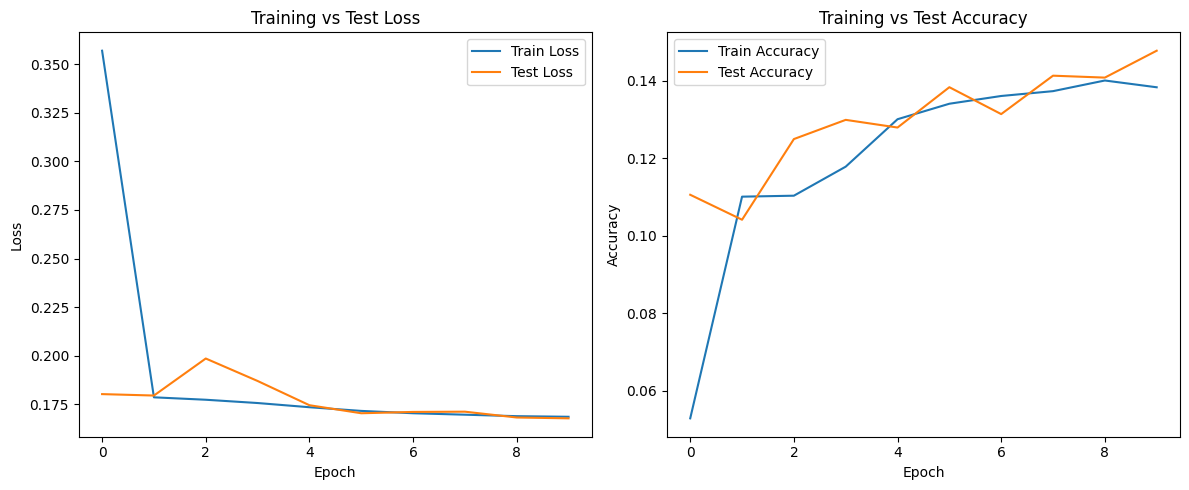

In [44]:
plot_training_history(history=history)